In [1]:
import copy
import numpy as np
import pandas as pd
import scipy.stats
import dftools
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.18/00


In [2]:
plt.style.use("cms")

In [3]:
_df_data = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "Data")
_df_mc = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "MC")
_df_mc_smooth = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "MCSmooth")
_df_mc_p4 = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "MCPoly4")
_df_mc_flat = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "MCFlat")

_df_data = _df_data.loc[~_df_data.index.duplicated(keep="first")]
_df_mc = _df_mc.loc[~_df_mc.index.duplicated(keep="first")]
_df_mc_smooth = _df_mc_smooth.loc[~_df_mc_smooth.index.duplicated(keep="first")]
_df_mc_p4 = _df_mc_p4.loc[~_df_mc_p4.index.duplicated(keep="first")]
_df_mc_flat = _df_mc_flat.loc[~_df_mc_flat.index.duplicated(keep="first")]

## Modify dataframes

Alter the dataframes, for example, to make or break correlations between systematic uncertainties, remove variations from particular sources, or switch to polyfit smoothing or a flat systematic

### Rename nuisances

In [4]:
region_mapping = {
    "Monojet": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "MonojetQCD": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleTau": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonMinus": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonPlus": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonQCD": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "DoubleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig2MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
}

for region, mapping in region_mapping.items():
    selection = (_df_mc.index.get_level_values("variation")=="") & (_df_mc.index.get_level_values("region")==region)
    tdf = _df_mc.loc[selection,:]
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Up")) & (_df_mc.index.get_level_values("region")==region)
    tdf_up = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Up": v.format(region=region)+"Up" for k, v in mapping.items()},
    )
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Down")) & (_df_mc.index.get_level_values("region")==region)
    tdf_do = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Down": v.format(region=region)+"Down" for k, v in mapping.items()},
    )
    _df_mc = pd.concat([tdf, tdf_up, tdf_do, _df_mc.loc[_df_mc.index.get_level_values("region")!=region,:].copy()], axis=0, sort=False)

## Remove nuisances

In [5]:
_df_mc.loc[("SingleElectron", "WJetsToLNu"),:].index.get_level_values("variation").unique()

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Index(['', 'alphasDown', 'alphasUp', 'btagSFDown', 'btagSFUp', 'd1kewDown',
       'd1kewUp', 'd1kqcdDown', 'd1kqcdUp', 'd2kewwDown', 'd2kewwUp',
       'd2kewzDown', 'd2kewzUp', 'd2kqcdDown', 'd2kqcdUp', 'd3kewwDown',
       'd3kewwUp', 'd3kewzDown', 'd3kewzUp', 'd3kqcdDown', 'd3kqcdUp',
       'dkmixDown', 'dkmixUp', 'eleEnergyScaleDown', 'eleEnergyScaleUp',
       'eleIdIsoTightDown', 'eleIdIsoTightUp', 'eleIdIsoVetoDown',
       'eleIdIsoVetoUp', 'eleRecoDown', 'eleRecoUp', 'eleTrigDown',
       'eleTrigUp', 'jerSFDown', 'jerSFUp', 'jesTotalDown', 'jesTotalUp',
       'lhePdfWeightDown', 'lhePdfWeightUp', 'lheScaleWeightDown',
       'lheScaleWeightUp', 'lumiDown', 'lumiUp',
       'metTrigMuonMultiplicitySystDown', 'metTrigMuonMultiplicitySystUp',
       'metTrigReferenceTriggerSystDown', 'metTrigReferenceTriggerSystUp',
       'metTrigRegionSystDown', 'metTrigRegionSystUp', 'muonIdLooseStatDown',
       'muonIdLooseStatUp', 'muonIdLooseSystDown', 'muonIdLooseSystUp',
       'muon

In [6]:
region_process_variations = {
    ("SingleMuon", "WJetsToLNu"): [
        "lheScaleWeight", "eleTrig",
        #"d1kqcd", "d2kqcd", "d3kqcd", "dkmix",
        #"d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz",
        #"lumi",
    ],
    ("SingleMuonPlus", "WJetsToLNu"): [
        "lheScaleWeight", "eleTrig",
        #"d1kqcd", "d2kqcd", "d3kqcd", "dkmix",
        #"d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz",
        #"lumi",
    ],
    ("SingleMuonMinus", "WJetsToLNu"): [
        "lheScaleWeight", "eleTrig",
        #"d1kqcd", "d2kqcd", "d3kqcd", "dkmix",
        #"d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz",
        #"lumi",
    ],
    ("SingleElectronPlus", "WJetsToLNu"): [
        "lheScaleWeight", "muonTrig",
        #"d1kqcd", "d2kqcd", "d3kqcd", "dkmix",
        #"d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz",
        #"lumi",
    ],
    ("SingleElectronMinus", "WJetsToLNu"): [
        "lheScaleWeight", "muonTrig",
        #"d1kqcd", "d2kqcd", "d3kqcd", "dkmix",
        #"d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz",
        #"lumi",
    ],
    ("SingleMuon", "QCD"): ["eleTrig", "jesTotal", "jerSF", "unclust"],
    ("SingleMuon", "MinorBkgs"): ["eleTrig", "lheScaleWeight", "jesTotal", "jerSF", "unclust"],
    ("SingleMuonPlus", "QCD"): ["eleTrig", "jesTotal", "jerSF", "unclust"],
    ("SingleMuonPlus", "MinorBkgs"): ["eleTrig", "lheScaleWeight", "jesTotal", "jerSF", "unclust"],
    ("SingleMuonMinus", "QCD"): ["eleTrig", "jesTotal", "jerSF", "unclust"],
    ("SingleMuonMinus", "MinorBkgs"): ["eleTrig", "lheScaleWeight", "jesTotal", "jerSF", "unclust"],
    ("SingleElectronPlus", "MinorBkgs"): ["muonTrig", "lheScaleWeight", "jesTotal", "jerSF", "unclust"],
    ("SingleElectronMinus", "MinorBkgs"): ["muonTrig", "lheScaleWeight", "jesTotal", "jerSF", "unclust"],
}

drops = [
    (r, p, v+"Up")
    for (r, p), vs in region_process_variations.items()
    for v in vs
] + [
    (r, p, v+"Down")
    for (r, p), vs in region_process_variations.items()
    for v in vs
]
_df_mc = _df_mc.drop(drops, errors='ignore')

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


## Use gaussian filter smoothing

In [7]:
wjets = [
    "lhePdfWeight", "jesTotal", "jerSF", "unclust", "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst",
    "muonIdTightStat", "muonIsoLooseSyst", "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose", "btagSF",
    "alphas",
]
minor_bkgs = [
    "lhePdfWeight", "lheScaleWeight", "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst", "muonIdTightStat",
    "muonIsoLooseSyst", "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose", "alphas",
]
qcd = [
    "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst", "muonIdTightStat", "muonIsoLooseSyst",
    "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose", "alphas"
]

region_process_variations = {
    ("SingleMuon", "WJetsToLNu"): wjets,
    ("SingleMuon", "MinorBkgs"): minor_bkgs,
    ("SingleMuon", "QCD"): qcd,
    ("SingleMuonPlus", "WJetsToLNu"): wjets,
    ("SingleMuonPlus", "MinorBkgs"): minor_bkgs,
    ("SingleMuonPlus", "QCD"): qcd,
    ("SingleMuonMinus", "WJetsToLNu"): wjets,
    ("SingleMuonMinus", "MinorBkgs"): minor_bkgs,
    ("SingleMuonMinus", "QCD"): qcd,
    ("SingleElectronPlus", "WJetsToLNu"): wjets,
    ("SingleElectronPlus", "MinorBkgs"): minor_bkgs,
    ("SingleElectronMinus", "WJetsToLNu"): wjets,
    ("SingleElectronMinus", "MinorBkgs"): minor_bkgs,
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_smooth.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass


/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


## Use polyfit smoothing

In [8]:
wjets = [
    "d1kqcd", "d2kqcd", "d3kqcd", "d1kew", "d2keww", "d3keww", "dkmix",
]

region_process_variations = {
    ("SingleMuon", "WJetsToLNu"): wjets,
    ("SingleMuonPlus", "WJetsToLNu"): wjets,
    ("SingleMuonMinus", "WJetsToLNu"): wjets,
    ("SingleElectronPlus", "WJetsToLNu"): wjets,
    ("SingleElectronMinus", "WJetsToLNu"): wjets,
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_p4.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass


## Use flat systematic


In [9]:
#qcd = ["jesTotal", "jerSF", "unclust", "pileup", "eleReco", "btagSF"]
qcd = ["pileup", "eleReco", "btagSF"]
#minors = ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight", "btagSF"]
minors = ["pileup", "eleIdIsoTight", "btagSF"]

process_variations = {
    ("SingleMuon", "MinorBkgs"): minors,
    ("SingleMuon", "QCD"): qcd,
    ("SingleMuonPlus", "MinorBkgs"): minors,
    ("SingleMuonPlus", "QCD"): qcd,
    ("SingleMuonMinus", "MinorBkgs"): minors,
    ("SingleMuonMinus", "QCD"): qcd,
    ("SingleElectronPlus", "MinorBkgs"): minors,
    ("SingleElectronMinus", "MinorBkgs"): minors,
}

for (region, process), variations in process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            _df_mc.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ] = _df_mc_flat.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ]

In [10]:
## take pileup and lheScaleWeight from mu+

In [11]:
#for vari in ["pileup", "lheScaleWeight"]:
#    for vtype in ["Up", "Down"]:
#        muplus_nom = _df_mc.loc[("SingleMuonPlus", pd.IndexSlice[:], ""), :].groupby(["process", "bin_min", "bin_max"]).sum()
#        muplus_vari = _df_mc.loc[("SingleMuonPlus", pd.IndexSlice[:], vari+vtype), :].groupby(["process", "bin_min", "bin_max"]).sum()
#
#        muminus_nom = _df_mc.loc[("SingleMuonMinus", pd.IndexSlice[:], ""), :]
#        print(muminus_nom.shape)
#        _df_mc.loc[("SingleMuonMinus", pd.IndexSlice[:], vari+vtype),:] = (muminus_nom*(muplus_vari/muplus_nom).values).values
#_df_mc.loc[("SingleMuonMinus", pd.IndexSlice[:], "pileupUp")]

## Symmetrize

In [12]:
#tdf = (
#    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
#    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
#)/2.
#tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
#tdf_up = tdf_nom + tdf
#tdf_do = tdf_nom - tdf
#tdf_up["variation"] = "jesTotalUp"
#tdf_do["variation"] = "jesTotalDown"
#
#tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
#tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
#_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalUp"),:] = tdf_up
#_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jesTotalDown"),:] = tdf_do

In [13]:
#tdf = (
#    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
#    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
#)/2.
#tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
#tdf_up = tdf_nom + tdf
#tdf_do = tdf_nom - tdf
#tdf_up["variation"] = "jerSFUp"
#tdf_do["variation"] = "jerSFDown"
#
#tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
#tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
#_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFUp"),:] = tdf_up
#_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "jerSFDown"),:] = tdf_do

In [14]:
#tdf = (
#    _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustUp"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
#    - _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustDown"),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
#)/2.
#tdf_nom = _df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], ""),:].groupby(["region", "process", "bin_min", "bin_max"]).sum()
#tdf_up = tdf_nom + tdf
#tdf_do = tdf_nom - tdf
#tdf_up["variation"] = "unclustUp"
#tdf_do["variation"] = "unclustDown"
#
#tdf_up = tdf_up.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
#tdf_do = tdf_do.set_index("variation", append=True).reorder_levels(["region", "process", "variation", "bin_min", "bin_max"]).sort_index()
#_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustUp"),:] = tdf_up
#_df_mc.loc[(pd.IndexSlice[:], pd.IndexSlice[:], "unclustDown"),:] = tdf_do

In [15]:
df_data = _df_data.unstack().unstack().loc[[
    ("MET", "SingleMuon"),
    ("MET", "SingleMuonPlus"),
    ("MET", "SingleMuonMinus"),
    ("SingleElectron", "SingleElectronPlus"),
    ("SingleElectron", "SingleElectronMinus"),
]].stack().stack().reset_index("trigger").drop("trigger", axis=1)
df_data.head(5)

count    sum_w   sum_ww
region     bin_min bin_max                           
SingleMuon 200.0   220.0    34774.0  34774.0  34774.0
           220.0   250.0    53463.0  53463.0  53463.0
           250.0   280.0    41620.0  41620.0  41620.0
           280.0   310.0    28725.0  28725.0  28725.0
           310.0   340.0    19420.0  19420.0  19420.0

In [16]:
df_mc = _df_mc.copy(deep=True)
df_mc.loc[:,"sum_w"] = np.maximum(1e-10, df_mc["sum_w"])
df_mc.head(30)

sum_w       sum_ww
region     process    variation bin_min bin_max                          
DoubleMuon DYJetsToLL           200.0   220.0    3236.184095   768.120728
                                220.0   250.0    5233.734667  1111.948738
                                250.0   280.0    4321.105366   650.961742
                                280.0   310.0    3081.230471   244.541571
                                310.0   340.0    2132.301105    94.152928
                                340.0   370.0    1475.857454    53.926664
                                370.0   400.0     992.210351    37.620910
                                400.0   430.0     663.230560    28.511451
                                430.0   470.0     560.985071    27.581216
                                470.0   510.0     344.081583    17.901991
                                510.0   550.0     224.266128    11.301424
                                550.0   590.0     143.025033     7.196915
                                590.0   640.0     115.355197     5.262883
                                640.0   690.0      68.455105     2.213242
                                690.0   740.0      40.639383     0.601003
                                740.0   790.0      25.331025     0.164831
                                790.0   840.0      17.234054     0.077535
                                840.0   900.0      12.872755     0.056071
                                900.0   960.0       7.699648     0.031386
                                960.0   1020.0      4.818195     0.020460
                                1020.0  1090.0      3.480534     0.013794
                                1090.0  1160.0      2.135376     0.008295
                                1160.0  1250.0      1.498013     0.005933
                                1250.0  1400.0      1.120919     0.004172
                                1400.0  1550.0      0.683578     0.002718
           MinorBkgs            200.0   220.0     183.419165   171.793242
                                220.0   250.0     317.971478   352.310804
                                250.0   280.0     221.964530   325.758244
                                280.0   310.0     215.624429   236.232757
                                310.0   340.0     168.794255   147.271603

## Run fits

In [17]:
bin_min = df_data.index.get_level_values("bin_min").unique().values
bin_max = df_data.index.get_level_values("bin_max").unique().values
bin_edge = np.array(list(bin_min) + [bin_max[-1]])
bin_edge

array([ 200.,  220.,  250.,  280.,  310.,  340.,  370.,  400.,  430.,
        470.,  510.,  550.,  590.,  640.,  690.,  740.,  790.,  840.,
        900.,  960., 1020., 1090., 1160., 1250., 1400., 1550.])

In [18]:
df_mc.index.get_level_values("variation").unique()

Index(['', 'alphasUp', 'btagSFUp', 'd1kewUp', 'd1kqcdUp', 'd2kewwUp',
       'd2kewzUp', 'd2kqcdUp', 'd3kewwUp', 'd3kewzUp',
       ...
       'metTrig0MuSystDown', 'metTrigSingleTauSystDown',
       'metTrigMonojetQCDSystUp', 'metTrigMonojetQCDSystDown',
       'metTrigMonojetSystUp', 'metTrigMonojetSystDown',
       'metTrigMuonMultiplicitySystDown', 'metTrigMuonMultiplicitySystUp',
       'metTrigRegionSystDown', 'metTrigRegionSystUp'],
      dtype='object', name='variation', length=109)

In [19]:
bins = (bin_min, bin_max)

regions = {
    "SingleMuonPlus":      ["WJetsToLNu", "MinorBkgs", "QCD"],
    "SingleMuonMinus":     ["WJetsToLNu", "MinorBkgs", "QCD"],
    #"SingleElectronPlus":  ["WJetsToLNu", "MinorBkgs"],
    #"SingleElectronMinus": ["WJetsToLNu", "MinorBkgs"],
}

config ={
    "regions": regions,
    "parameters": [
        {"name": "rWJetsToLNu",          "value": 1., "limit": (0., 2.),  "fixed": False, "constraint": "free"},
        {"name": "rWJetsToLPlusNuNorm",  "value": 1., "limit": (0., 2.),  "fixed": False, "constraint": "free"},
        {"name": "rWJetsToLPlusNuShape", "value": 0., "limit": (-1., 1.), "fixed": False, "constraint": "free"},
        
        #{"name": "metTrig0MuSyst",              "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig1MuSyst",              "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "metTrig2MuSyst",              "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrigReferenceTriggerSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "metTrig{}Syst".format(r), "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"}
        for r in ["SingleMuonPlus", "SingleMuonMinus"] if r in regions.keys()
    ] + [
        #{"name": "muonIdLooseSyst",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonIdLooseStat",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightSyst",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightStat",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonIsoLooseSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonIsoLooseStat", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightStat", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonTrig",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonPtScale",      "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        #{"name": "eleIdIsoTight",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleIdIsoVeto",   "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleReco",        "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleTrig",        "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "eleEnergyScale", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "photonIdLoose",       "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "photonPixelSeedVeto", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "photonEnergyScale",   "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "tauIdVLoose", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "tauIdTight",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "tauPtScale",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "btagSF",      "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotal",    "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "jerSF",       "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "unclust",     "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "lumi",      "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "pileup",    "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "prefiring", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "d1kqcd",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kqcd",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kqcd",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d1kew",          "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kewz",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2keww",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kewz",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3keww",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "dkmix",          "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "alphas",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "lhePdfWeight",   "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "lheScaleWeight", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "{}_mcstat_bin{}".format(r, idx), "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gamma"}
        for r in regions.keys()
        for idx in range(len(bin_min))
    ],
    "scale_functions": {
        ("SingleMuonPlus",      "WJetsToLNu"):  "x, w, p: p['rWJetsToLNu']*(p['rWJetsToLPlusNuNorm'] + p['rWJetsToLPlusNuShape']*(x * (w.sum())/((x*w).sum()) - 1.))",
        ("SingleMuonMinus",     "WJetsToLNu"):  "x, w, p: p['rWJetsToLNu']",
        #("SingleElectronPlus",  "WJetsToLNu"):  "x, w, p: p['rWJetsToLNu']",
        #("SingleElectronMinus", "WJetsToLNu"):  "x, w, p: p['rWJetsToLNu']*(p['rWJetsToLPlusNuNorm'] + p['rWJetsToLPlusNuShape']*(x * (w.sum())/((x*w).sum()) - 1.))",
    }
}

In [20]:
len(config["parameters"])

85

## Asimov fit

In [21]:
#model = dftools.fitting.NLLModel2(df_data, df_mc, config, same_bin_widths=True)
#minimizer = model.fit(asimov=True, migrad=False, minos=False)
#minimizer.migrad(ncall=100_000)

In [22]:
#results = dftools.fitting.run_impacts(
#    minimizer.parameters, "rWJetsToLNu",
#    nll_args=(df_data, df_mc, bins, config),
#    nll_kwargs=dict(same_bin_widths=True),
#    fit_kwargs=dict(asimov=True, migrad=False, minos=False),
#    migrad_kwargs=dict(ncall=100_000),
#    pysge_function="sge_submit",
#    pysge_args=("zfit", "_ccsp_temp"),
#    pysge_kwargs=dict(options="-q hep.q", dill_kw={"recurse": False}),
#    params_guess=list(minimizer.args),
#)

In [23]:
#pd.set_option('display.float_format', lambda x: '%.5f' % x)
#pd.set_option('display.max_rows', None)
#df = pd.DataFrame(results)
#df["envelope"] = np.abs(df[["poi_paramup", "poi_paramdown"]]).max(axis=1)
#df = df.sort_values("envelope", ascending=False).reset_index(drop=True).set_index(["param", "poi"])
#df.loc[~df.index.get_level_values("param").str.contains("mcstat"),:]

## Observed fit

In [32]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=False)
minimizer = model.fit(migrad=False, minos=False)
minimizer.migrad(ncall=100_000)

------------------------------------------------------------------
| FCN = 925.1                   |   Ncalls=20937 (20937 total)   |
| EDM = 2.58E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
|   | Name                         |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------------------------
| 0 | rWJetsToLNu                  |   1.16    |   0.09    |            |            |    0    |    2    |       |
| 1 | rWJetsToLPlusNuNorm          |   0.975   |   0.014   |            |            |    0    |    2    |       |
| 2 | rWJetsToLPlusNuShape         |   0.006   |   0.026   |            |            |   -1    |    1    |       |
| 3 | metTrig1MuSyst               |   0.18    |   0.88    |            |            |   -3    |    3    |       |
| 4 | metTrigReferenceTriggerSyst  |   0.009   |   0.980   |            |            |   -3    |    3    |       |
| 5 | metTrigSingleMuonPlusSyst    |    0.7    |    0.9    |            |            |   -3    |    3    |       |
| 6 | metTrigSingleMuonMinusSyst   |    0.5    |    0.9    |            |            |   -3    |    3    |       |
| 7 | muonIdTightSyst              |   -0.04   |    0.98   |            |            |   -3    |    3    |       |
| 8 | muonIdTightStat              |  -0.015   |   0.982   |            |            |   -3    |    3    |       |
| 9 | muonIsoTightSyst             |  -0.003   |   0.982   |            |            |   -3    |    3    |       |
| 10| muonIsoTightStat             |  -0.009   |   0.982   |            |            |   -3    |    3    |       |
| 11| eleIdIsoVeto                 |   0.000   |   0.982   |            |            |   -3    |    3    |       |
| 12| eleReco                      |   0.000   |   0.982   |            |            |   -3    |    3    |       |
| 13| eleTrig                      |    0.0    |    1.0    |            |            |   -3    |    3    |       |
| 14| photonIdLoose                |   0.000   |   0.982   |            |            |   -3    |    3    |       |
| 15| photonPixelSeedVeto          |   0.000   |   0.982   |            |            |   -3    |    3    |       |
| 16| tauIdVLoose                  |  -0.015   |   0.984   |            |            |   -3    |    3    |       |
| 17| btagSF                       |   0.08    |   0.91    |            |            |   -3    |    3    |       |
| 18| jesTotal                     |   0.22    |   0.99    |            |            |   -3    |    3    |       |
| 19| jerSF                        |    0.7    |    0.8    |            |            |   -3    |    3    |       |
| 20| unclust                      |   -0.8    |    0.7    |            |            |   -3    |    3    |       |
| 21| lumi                         |   -0.09   |    0.98   |            |            |   -3    |    3    |       |
| 22| pileup                       |   0.026   |   0.792   |            |            |   -3    |    3    |       |
| 23| prefiring                    |  -0.025   |   0.981   |            |            |   -3    |    3    |       |
| 24| d1kqcd                       |   0.04    |   0.94    |            |            |   -3

In [29]:
minimizer.minos("rWJetsToLPlusNuNorm")
minimizer.minos("rWJetsToLPlusNuShape")

-------------------------------------------------
| rWJetsToLPlusNuNorm |            Valid            |
-------------------------------------------------
|      Error      |    -0.013    |     0.013    |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
| rWJetsToLPlusNuShape |            Valid            |
-------------------------------------------------
|      Error      |    -0.026    |     0.026    |
|      Valid      |     True     |     True     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------

In [30]:
param = "rWJetsToLPlusNuNorm"
print(
    "{:.3f} + {:.3f} - {:.3f}".format(
        minimizer.values[param],
        minimizer.merrors[(param, 1.)],
        -minimizer.merrors[(param, -1.)],
    )
) 

0.976 + 0.013 - 0.013


In [31]:
param = "rWJetsToLPlusNuShape"
print(
    "{:.3f} + {:.3f} - {:.3f}".format(
        minimizer.values[param],
        minimizer.merrors[(param, 1.)],
        -minimizer.merrors[(param, -1.)],
    )
) 

0.006 + 0.026 - 0.026


In [65]:
results = dftools.fitting.run_impacts(
    minimizer.parameters, "rWJetsToLPlusNuNorm",
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G", dill_kw={"recurse": False}),
    params_guess=list(minimizer.args),
)

2019-09-27 18:05:09,598 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/background_prediction/wjets/_ccsp_temp/tpd_20190927_180509_4ozamgx_


2019-09-27 18:05:13,246 - pysge.submitter - INFO - Submitted 9931498.1-85:1


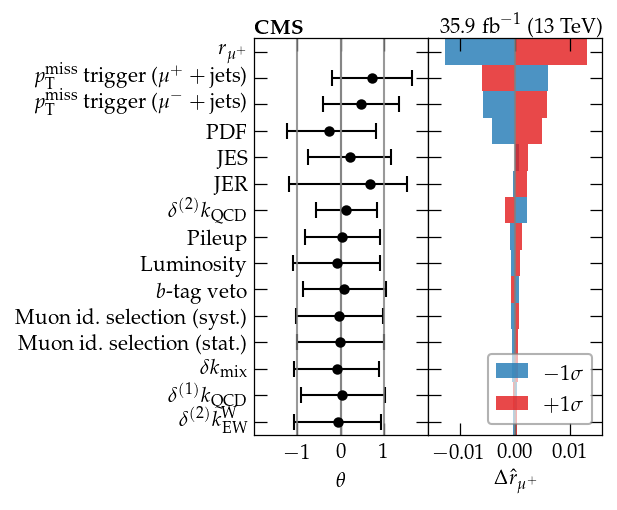

In [66]:
df = pd.DataFrame(results)
df["envelope"] = np.abs(df[["poi_paramup", "poi_paramdown"]]).max(axis=1)
df = df.sort_values("envelope").reset_index(drop=True).set_index(["param", "poi"])
selection = (
    #~df.index.get_level_values("param").str.contains("mcstat")
    df.index.get_level_values("param").isin([
        "rWJetsToLPlusNuNorm",
        "metTrigSingleMuonPlusSyst",
        "metTrigSingleMuonMinusSyst",
        "lhePdfWeight", "jesTotal", "jerSF", "d2kqcd",
        "pileup", "lumi", "btagSF", "muonIdTightStat",
        "muonIdTightSyst", "dkmix", "d1kqcd", "d2keww",
        "tauIdVLoose", "prefiring", "d3kqcd", "d1kew",
        "unclust", "metTrig1MuSyst",
    ])
)
tdf = df.loc[selection,:].drop("envelope", axis=1).iloc[-15:]
tdf.loc[("rWJetsToLPlusNuNorm", "rWJetsToLPlusNuNorm"),"param_value"] = np.nan
conv = dftools.draw.nuisance_names
conv["rWJetsToLPlusNuNorm"] = r'$r_{\mu^+}$'
conv["metTrigSingleMuonPlusSyst"] = r'$p_{\mathrm{T}}^{\mathrm{miss}}$ trigger ($\mu^+ +\mathrm{jets}$)'
conv["metTrigSingleMuonMinusSyst"] = r'$p_{\mathrm{T}}^{\mathrm{miss}}$ trigger ($\mu^- +\mathrm{jets}$)'
fig, ax = dftools.draw.draw_impacts(
    tdf, converter=conv
)

ax[0].text(
    0, 1, r'$\mathbf{CMS}$', ha='left', va='bottom',
    transform=ax[0].transAxes,
)
ax[1].text(
    1, 1, r'$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)', ha='right', va='bottom',
    transform=ax[1].transAxes,
)
ax[1].set_xlabel(r'$\Delta \hat{r}_{\mu^+}$')
ax[1].legend(loc=4, fancybox=True, edgecolor="gray")
fig.set_size_inches(3,3.5)
fig.align_labels(ax)
fig.savefig("plots/impacts_tfmup2munwj.pdf", format='pdf', bbox_inches='tight')

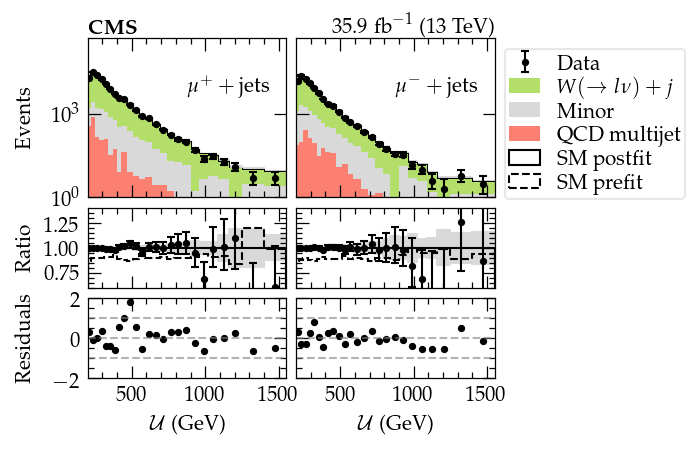

In [67]:
fig, ax = plt.subplots(
    figsize=(3.5, 3), dpi=150,
    nrows=3, ncols=2,
    sharex='col', sharey='row',
    gridspec_kw={
        "height_ratios": (2,1,1),
        "hspace": 0.1, "wspace": 0.05,
    },
)
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(model.bins["SingleMuonPlus"][0][0], model.bins["SingleMuonPlus"][1][-1])
ax[0,1].set_xlim(model.bins["SingleMuonPlus"][0][0], model.bins["SingleMuonPlus"][1][-1])

model.draw_data("SingleMuonPlus", ax[0,0], label="Data")
model.draw_prediction_total("SingleMuonPlus", ax[0,0])
model.draw_prediction_procs("SingleMuonPlus", ax[0,0])
model.draw_data("SingleMuonPlus", ax[1,0], ratio=True)
model.draw_prediction_total("SingleMuonPlus", ax[1,0], ratio=True, hkwargs={"label": "SM postfit"})
model.draw_prediction_total("SingleMuonPlus", ax[1,0], ratio=True, prefit=True, band=False, hkwargs={"label": "SM prefit"})
model.draw_data("SingleMuonPlus", ax[2,0], pull=True)

model.draw_data("SingleMuonMinus", ax[0,1])
model.draw_prediction_total("SingleMuonMinus", ax[0,1])
model.draw_prediction_procs("SingleMuonMinus", ax[0,1])
model.draw_data("SingleMuonMinus", ax[1,1], ratio=True)
model.draw_prediction_total("SingleMuonMinus", ax[1,1], ratio=True)
model.draw_prediction_total("SingleMuonMinus", ax[1,1], ratio=True, prefit=True, band=False)
model.draw_data("SingleMuonMinus", ax[2,1], pull=True)

ax[0,0].set_ylim(1, 5e5)
ax[1,0].set_ylim(0.6, 1.4)
ax[2,0].set_ylim(-2, 2)

ax[0,1].set_ylim(1, 5e5)
ax[1,1].set_ylim(0.6, 1.4)
ax[2,1].set_ylim(-2, 2)

ax[2,0].axhline(0., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,0].axhline(1., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,0].axhline(-1., lw=1, ls='--', color='gray', alpha=0.6)

ax[2,1].axhline(0., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,1].axhline(1., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,1].axhline(-1., lw=1, ls='--', color='gray', alpha=0.6)

ax[0,0].set_ylabel('Events')
ax[1,0].set_ylabel('Ratio')
ax[2,0].set_ylabel('Residuals')
ax[2,0].set_xlabel('$\mathcal{U}$ (GeV)')
ax[2,1].set_xlabel('$\mathcal{U}$ (GeV)')

h1, l1 = ax[0,0].get_legend_handles_labels()
h2, l2 = ax[1,0].get_legend_handles_labels()
ax[0,1].legend(
    h1[::-1]+h2, l1[::-1]+l2,
    loc=2, bbox_to_anchor=(1,1),
    fancybox=True, edgecolor="#d9d9d9",
    labelspacing=0.1, borderpad=0.2,
)

ax[0,0].text(0.5, 0.7, r'$\mu^{+}+\mathrm{jets}$', ha='left', va='center', transform=ax[0,0].transAxes)
ax[0,1].text(0.5, 0.7, r'$\mu^{-}+\mathrm{jets}$', ha='left', va='center', transform=ax[0,1].transAxes)

ax[0,0].text(0, 1, r'$\mathbf{CMS}$', ha='left', va='bottom', transform=ax[0,0].transAxes)
ax[0,1].text(1, 1, r'$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)', ha='right', va='bottom', transform=ax[0,1].transAxes)
fig.align_labels(ax)
fig.savefig("plots/postfit_tfmup2munwj.pdf", format="pdf", bbox_inches='tight')
pass

## View parameter effects

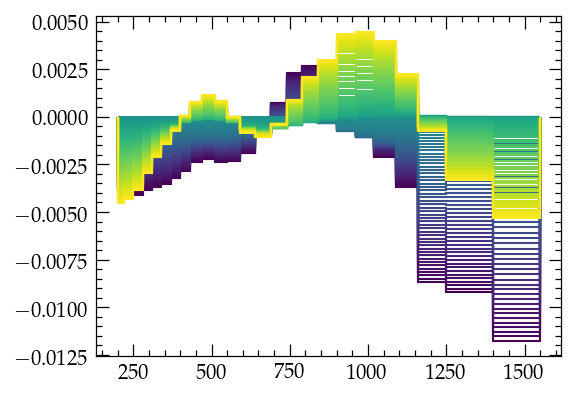

In [40]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
parameters = model.parameters

region = "SingleMuonPlus"
nuis = "jerSF"

nom = model.predictions(region)["prediction"]
binmin, binmax = model.bins[region]

fig, ax = plt.subplots()

ndiv = 100
cmap = plt.get_cmap('viridis', ndiv+1)

for idx, theta in enumerate(np.linspace(-1., 1., 101)):
    parameters[nuis] = theta
    model.set_parameters(parameters)
    vari = model.predictions(region)["prediction"]

    ax.hist(
        binmin, bins=list(binmin)+[binmax[-1]], weights=vari/nom-1,
        histtype='step', color=cmap(idx),
    )

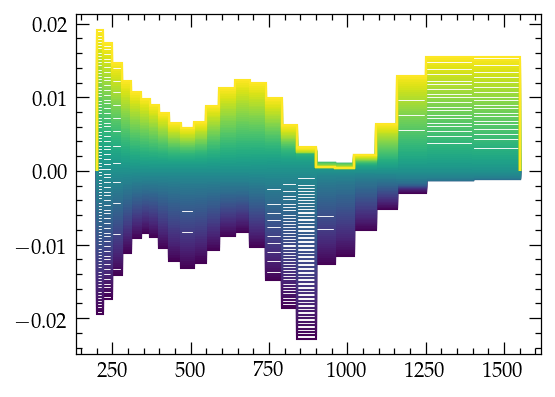

In [39]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
parameters = model.parameters

region = "SingleMuonMinus"
nuis = "jesTotal"

nom = model.predictions(region)["prediction"]
binmin, binmax = model.bins[region]

fig, ax = plt.subplots()

ndiv = 100
cmap = plt.get_cmap('viridis', ndiv+1)

for idx, theta in enumerate(np.linspace(-1., 1., 101)):
    parameters[nuis] = theta
    model.set_parameters(parameters)
    vari = model.predictions(region)["prediction"]

    ax.hist(
        binmin, bins=list(binmin)+[binmax[-1]], weights=vari/nom-1,
        histtype='step', color=cmap(idx),
    )

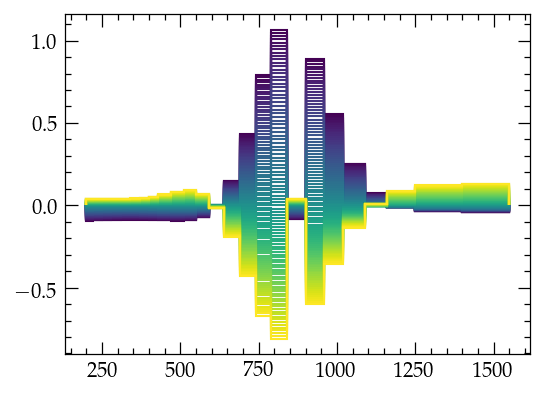

In [35]:
model = dftools.fitting.NLLModel2(df_data, df_mc, config, same_bin_widths=True)
parameters = model.parameters

region = "SingleMuonMinus"
proc = "MinorBkgs"
nuis = "lheScaleWeight"

nom = model.prediction(region).loc[proc]
binmin, binmax = model.bins[region]

fig, ax = plt.subplots()

ndiv = 100
cmap = plt.get_cmap('viridis', ndiv+1)

for idx, theta in enumerate(np.linspace(-1., 1., 101)):
    parameters[nuis] = theta
    model.set_parameters(parameters)
    vari = model.prediction(region).loc[proc]

    ax.hist(
        binmin, bins=list(binmin)+[binmax[-1]], weights=vari/nom-1,
        histtype='step', color=cmap(idx),
    )

KeyError: 'SingleElectronMinus'

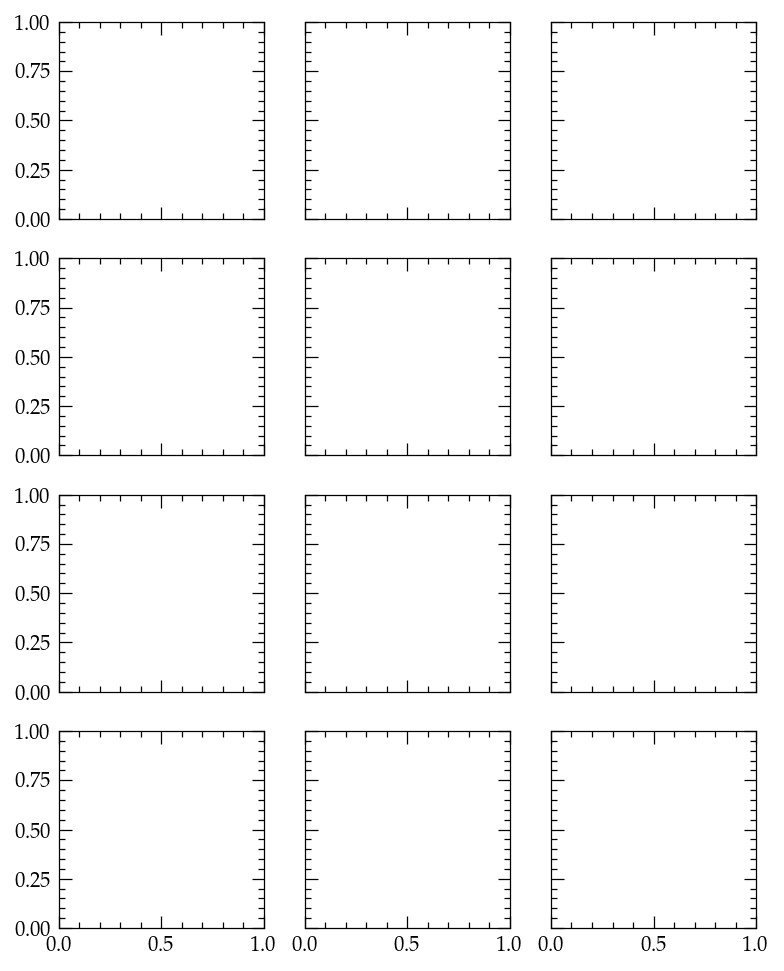

In [34]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
parameters = copy.deepcopy(model.parameters)

bins = model.bins["SingleMuonPlus"]
process = "QCD"
pred_nom_m = model.prediction("SingleMuonPlus").loc[(process)].values
pred_nom_e = model.prediction("SingleMuonMinus").loc[(process)].values

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)

nuisances = [
    "unclust", "jesTotal", "jerSF", "lheScaleWeight"
]
fig, ax = plt.subplots(
    figsize=(6, 2*len(nuisances)), dpi=150,
    nrows=len(nuisances), ncols=3,
    sharex=True, sharey='row',
)
    
for nidx, nuis in enumerate(nuisances):
    for idx, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams = copy.deepcopy(parameters)
        tparams[nuis] = theta
        model.set_parameters(tparams)
        pred = model.predictions(region)["prediction"].values
        
        if len(nuisances)>1:
            row = nidx
            tax = ax[row,0]
        else:
            tax = ax[0]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/pred_nom-1.,
            histtype='step',
            color=cmap(idx),
        )
        tax.legend([], [], loc=2, title=nuis)
    
#import matplotlib as mpl
#norm = mpl.colors.Normalize(vmin=-2., vmax=2.)
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])
#cbar = fig.colorbar(sm)
#cbar.set_label(r'$\theta$')

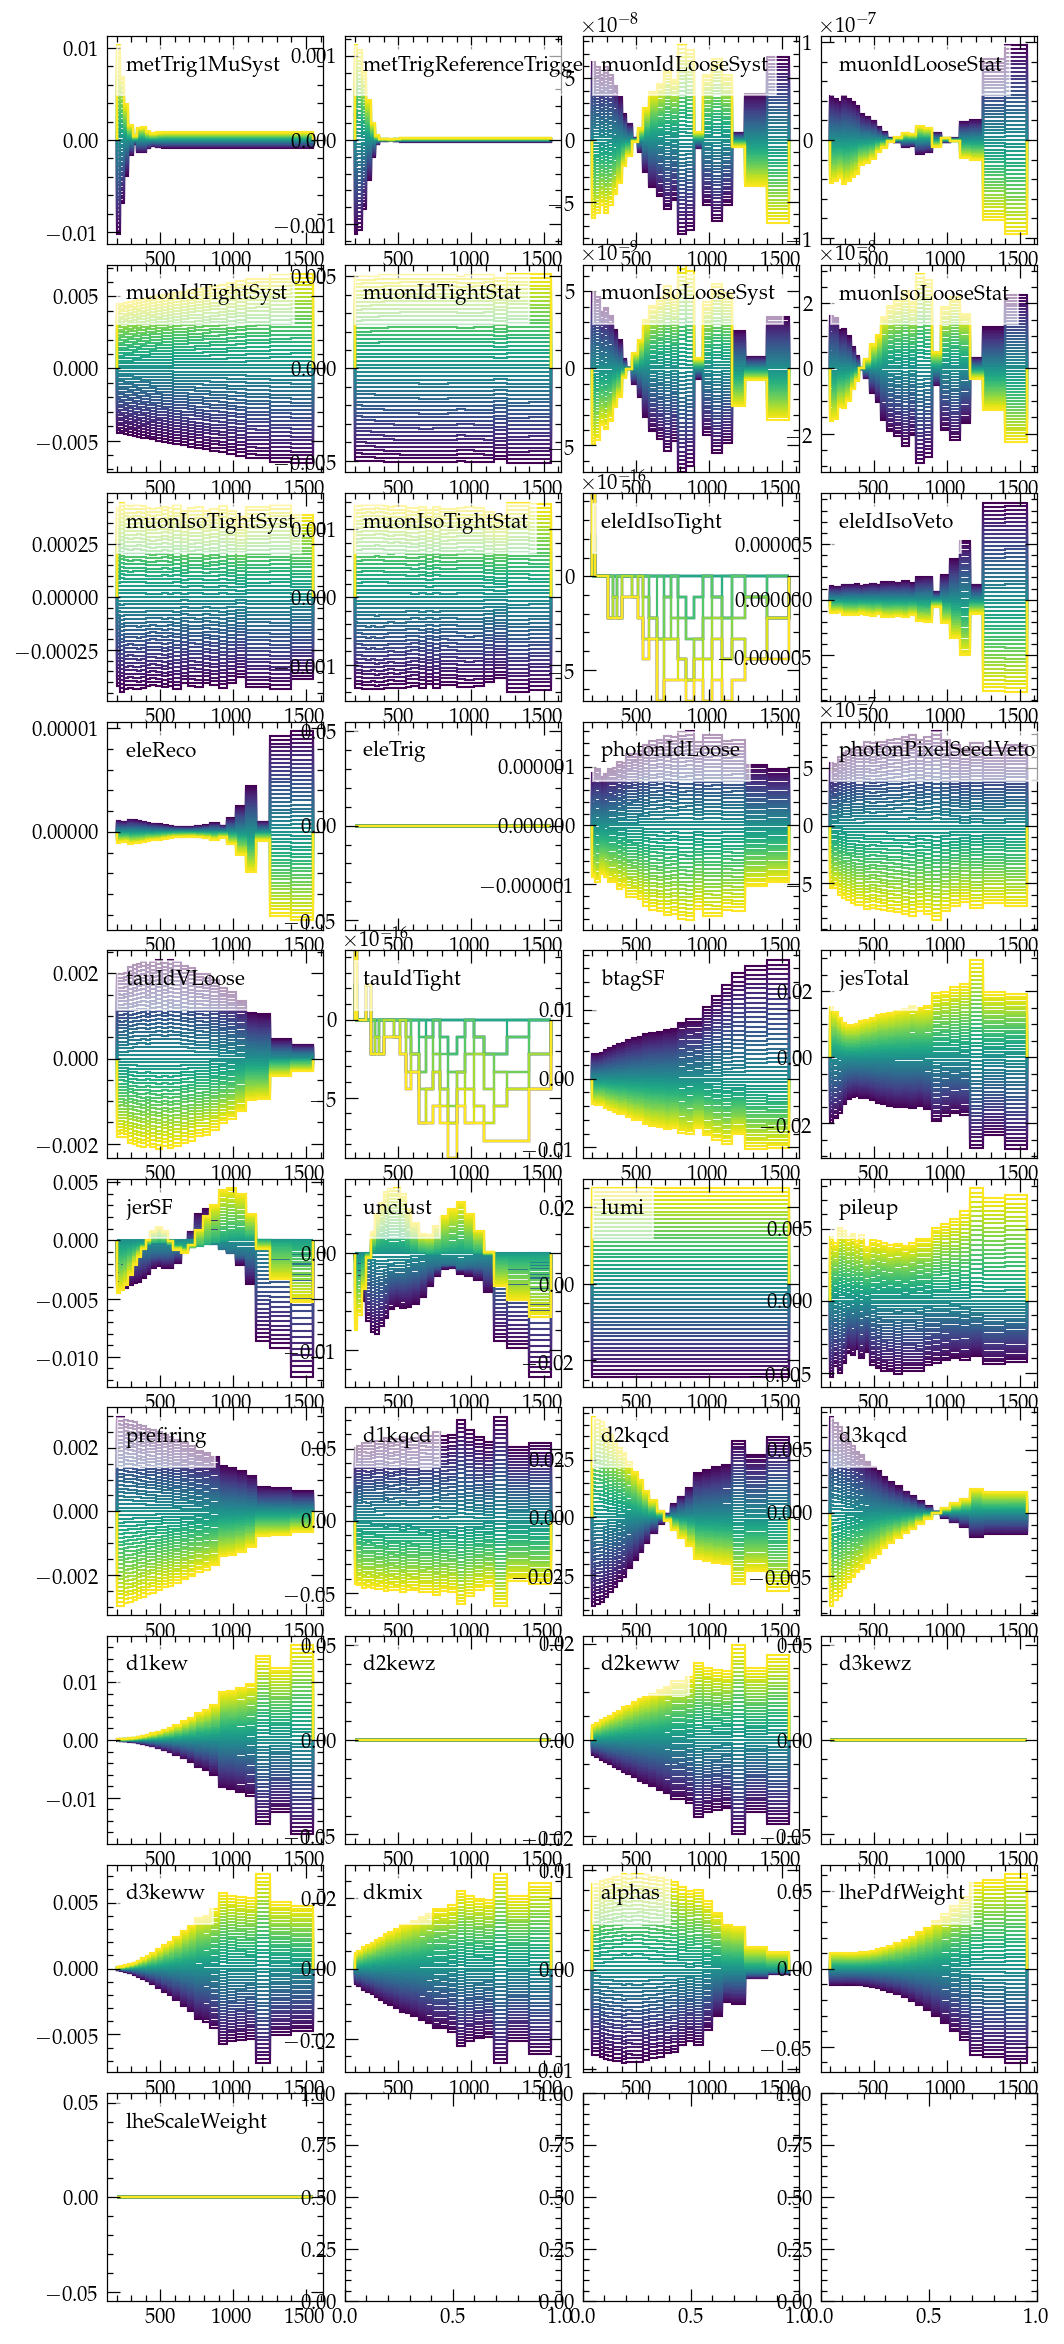

In [54]:
parameters = [
    'metTrig1MuSyst', 'metTrigReferenceTriggerSyst', 'muonIdLooseSyst', 'muonIdLooseStat', 'muonIdTightSyst', 'muonIdTightStat', 'muonIsoLooseSyst', 'muonIsoLooseStat', 'muonIsoTightSyst', 'muonIsoTightStat',
    'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig', 'photonIdLoose', 'photonPixelSeedVeto', 'tauIdVLoose', 'tauIdTight', 'btagSF', 'jesTotal', 'jerSF', 'unclust', 'lumi', 'pileup', 'prefiring', 'd1kqcd',
    'd2kqcd', 'd3kqcd', 'd1kew', 'd2kewz', 'd2keww', 'd3kewz', 'd3keww', 'dkmix', 'alphas', 'lhePdfWeight', 'lheScaleWeight',
]

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
region = "SingleMuonPlus"
bins = model.bins[region]
pred_nom = model.predictions(region)["prediction"].values

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = len(parameters)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, param in enumerate(parameters):
    model.set_parameters(mod_params)
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[param] = theta
        model.set_parameters(tparams)
        pred = model.predictions("SingleMuonPlus")["prediction"].values
    
        row = idx//4
        col = idx%4
        if len(parameters)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/pred_nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=param)


/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


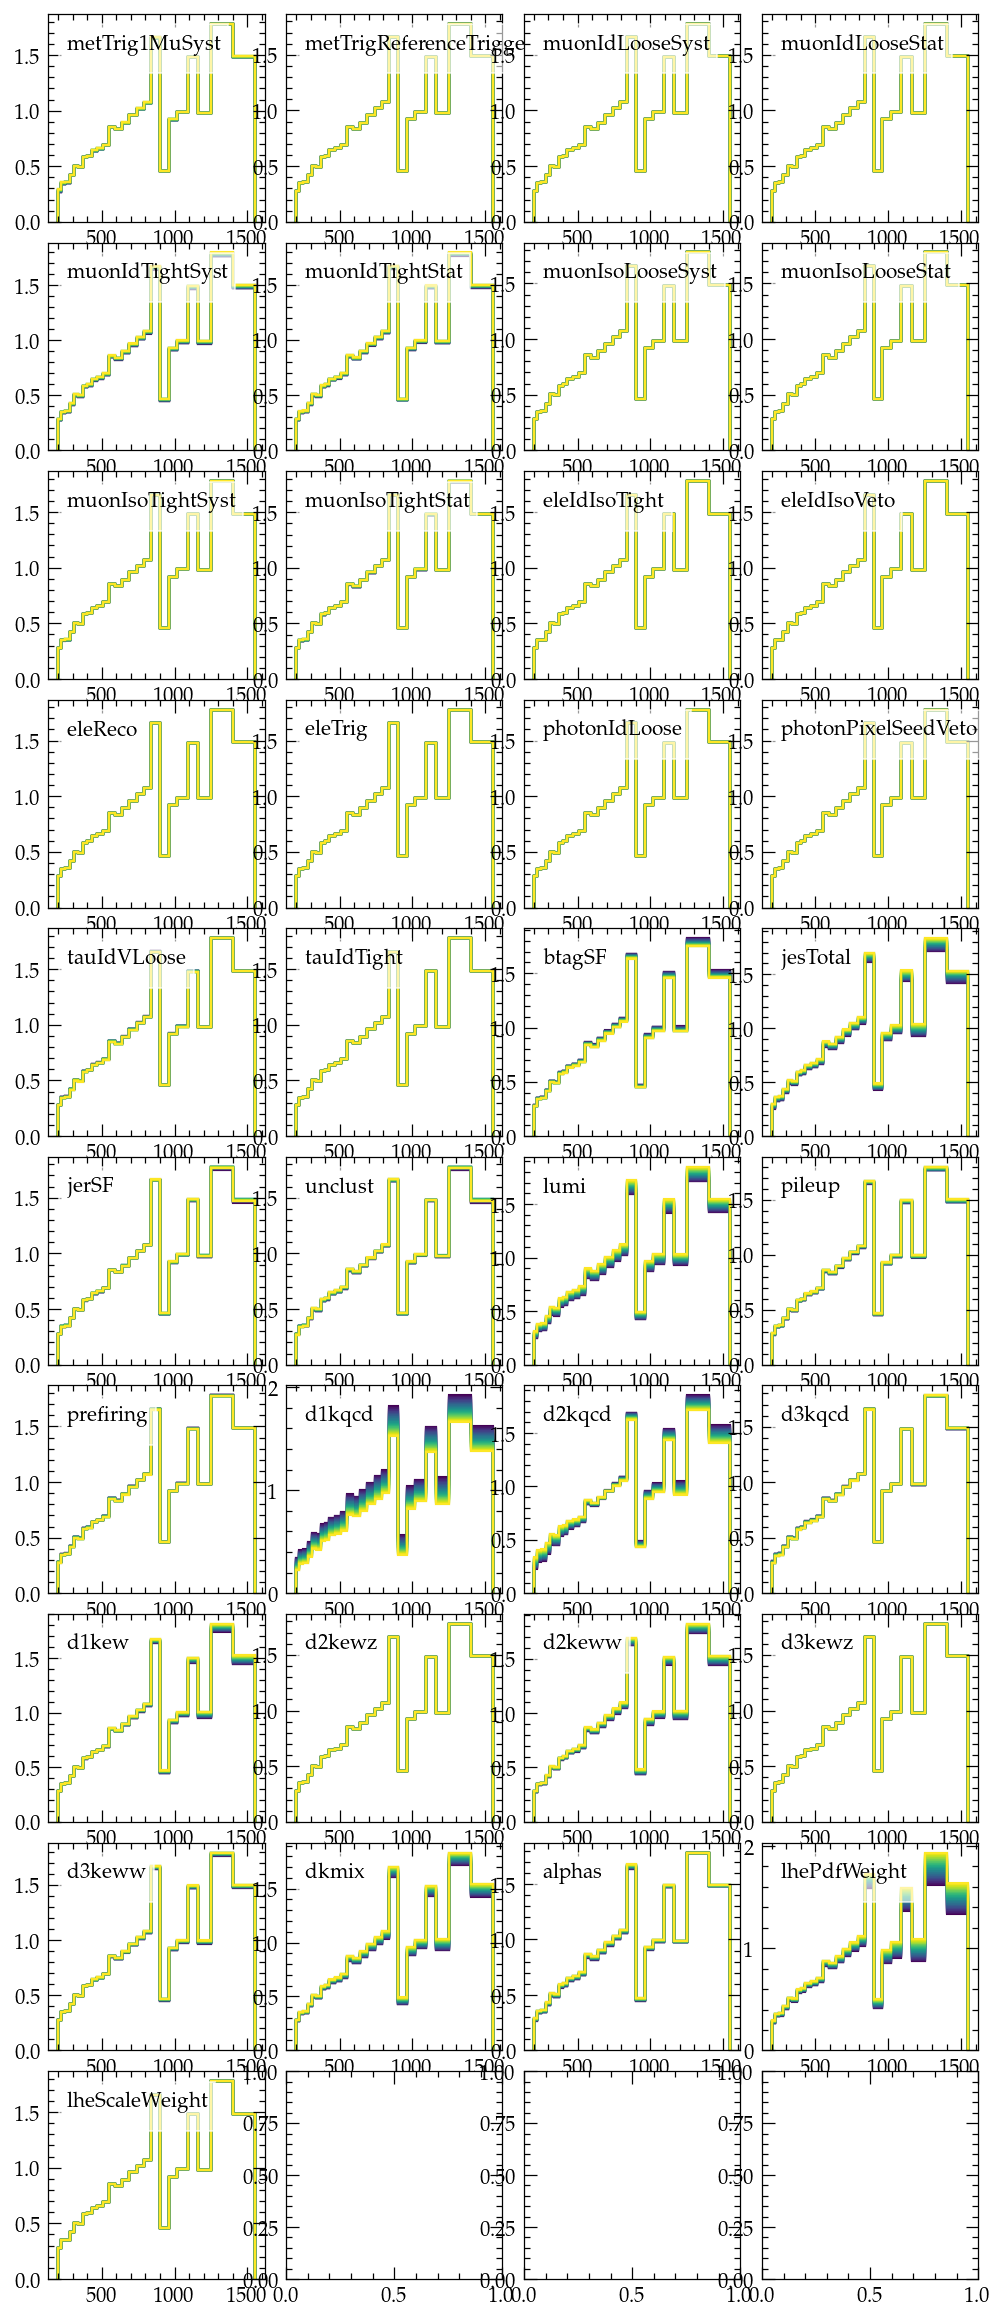

In [55]:
parameters = [
    'metTrig1MuSyst', 'metTrigReferenceTriggerSyst', 'muonIdLooseSyst', 'muonIdLooseStat', 'muonIdTightSyst', 'muonIdTightStat', 'muonIsoLooseSyst', 'muonIsoLooseStat', 'muonIsoTightSyst', 'muonIsoTightStat',
    'eleIdIsoTight', 'eleIdIsoVeto', 'eleReco', 'eleTrig', 'photonIdLoose', 'photonPixelSeedVeto', 'tauIdVLoose', 'tauIdTight', 'btagSF', 'jesTotal', 'jerSF', 'unclust', 'lumi', 'pileup', 'prefiring', 'd1kqcd',
    'd2kqcd', 'd3kqcd', 'd1kew', 'd2kewz', 'd2keww', 'd3kewz', 'd3keww', 'dkmix', 'alphas', 'lhePdfWeight', 'lheScaleWeight',
]

model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
mod_params = copy.deepcopy(model.parameters)
region = "SingleMuonMinus"
bins = model.bins[region]
pred_nom = model.predictions(region)["prediction"].values

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)
nrows = len(parameters)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

for idx, param in enumerate(parameters):
    model.set_parameters(mod_params)
    tparams = copy.deepcopy(mod_params)
    for tid, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams[param] = theta
        model.set_parameters(tparams)
        pred = model.predictions("SingleMuonPlus")["prediction"].values
    
        row = idx//4
        col = idx%4
        if len(parameters)<5:
            tax = ax[col]
        else:
            tax = ax[row,col]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred/pred_nom-1.,
            histtype='step',
            color=cmap(tid),
        )
    tax.legend([], [], loc=2, title=param)


## Naive nll scans

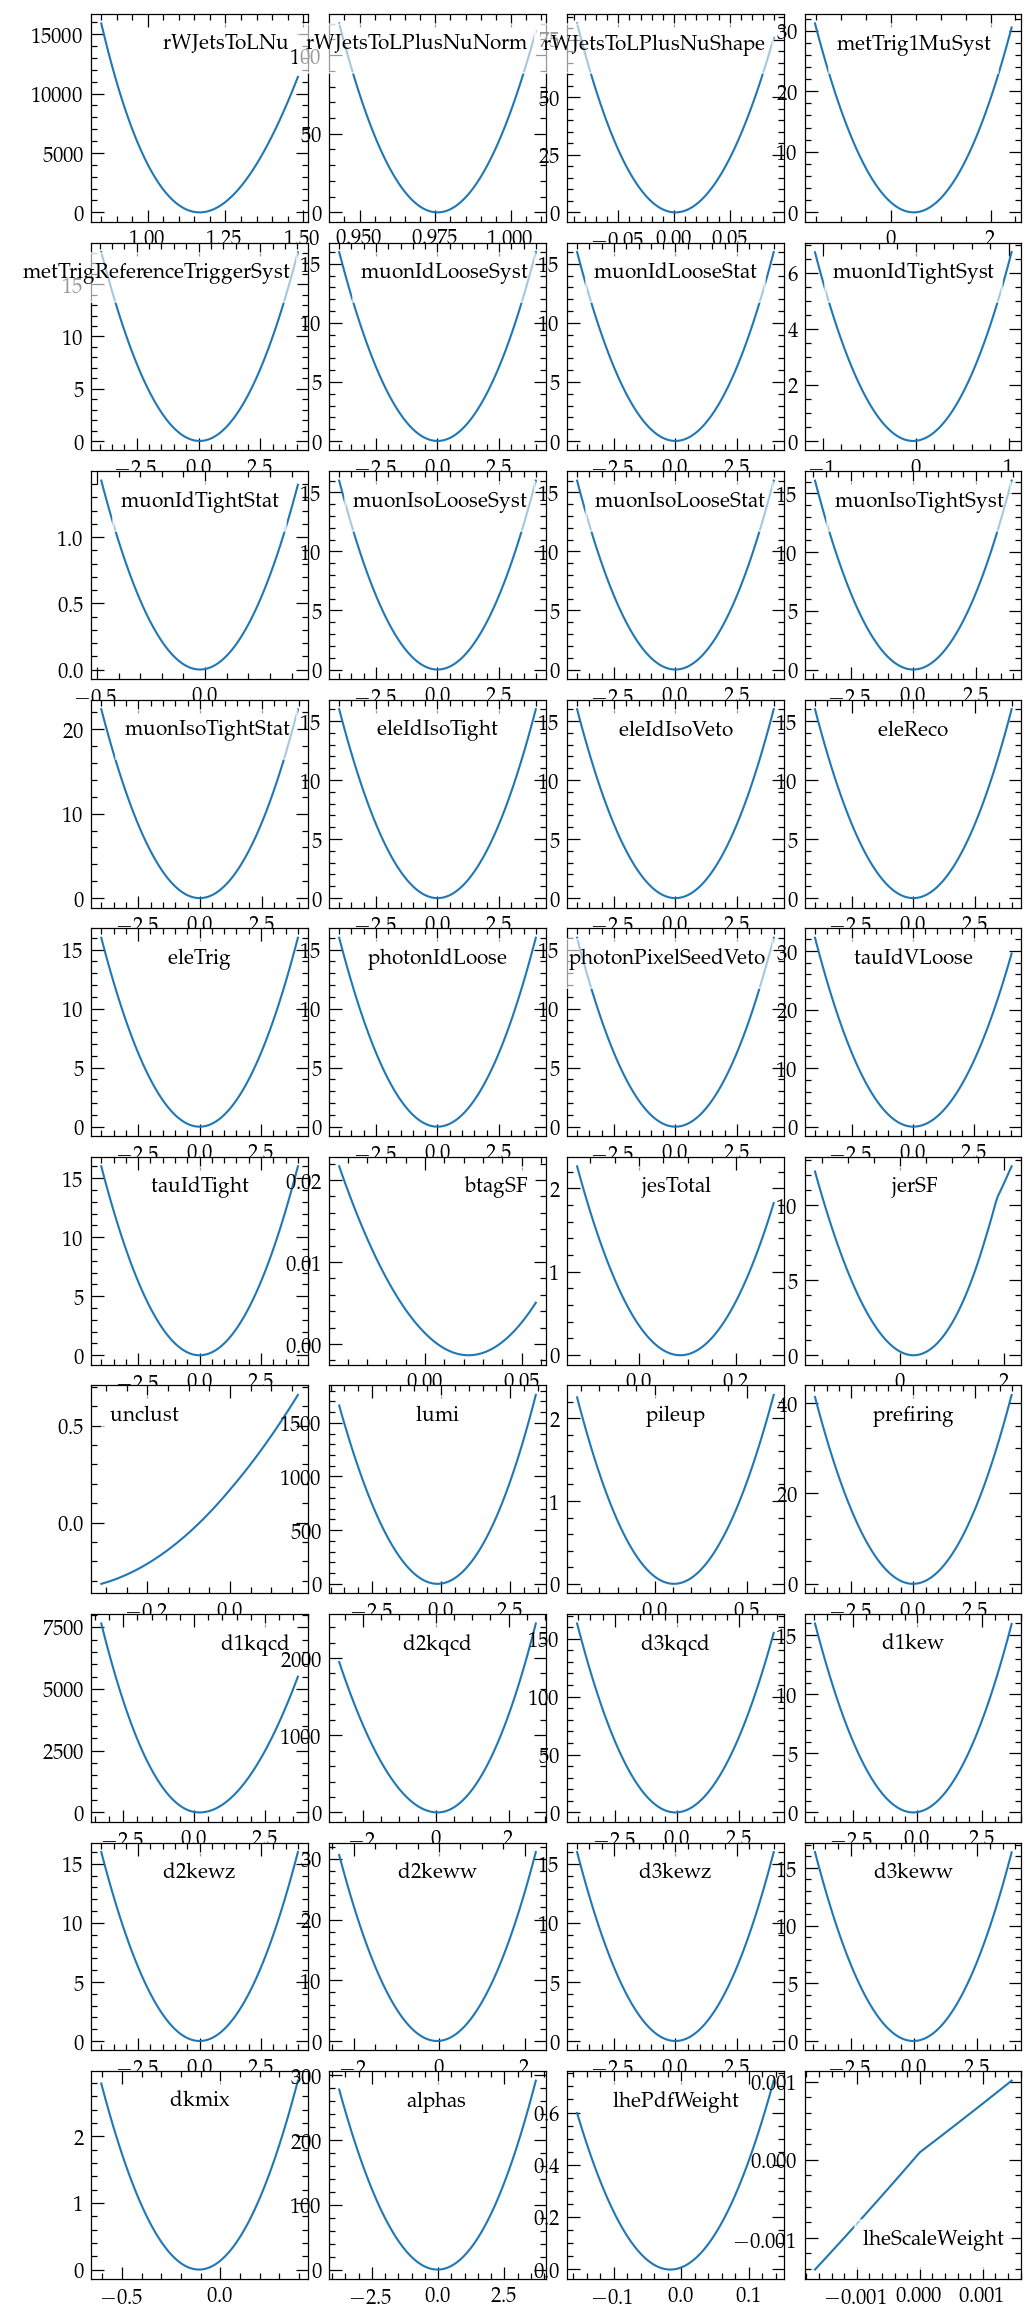

In [33]:
parameters = [
    'rWJetsToLNu', 'rWJetsToLPlusNuNorm', 'rWJetsToLPlusNuShape', 'metTrig1MuSyst', 'metTrigReferenceTriggerSyst', 'muonIdLooseSyst', 'muonIdLooseStat',
    'muonIdTightSyst', 'muonIdTightStat', 'muonIsoLooseSyst', 'muonIsoLooseStat', 'muonIsoTightSyst', 'muonIsoTightStat', 'eleIdIsoTight', 'eleIdIsoVeto',
    'eleReco', 'eleTrig', 'photonIdLoose', 'photonPixelSeedVeto', 'tauIdVLoose', 'tauIdTight', 'btagSF', 'jesTotal', 'jerSF', 'unclust', 'lumi', 'pileup',
    'prefiring', 'd1kqcd', 'd2kqcd', 'd3kqcd', 'd1kew', 'd2kewz', 'd2keww', 'd3kewz', 'd3keww', 'dkmix', 'alphas', 'lhePdfWeight', 'lheScaleWeight',
]
nrows = (len(parameters)-1)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

pvals = dict(minimizer.values)
fval = minimizer.fval

for idx, param in enumerate(parameters):
    x, y = minimizer.profile(param, subtract_min=True, bound=4)
    row = idx//4
    col = idx%4
    ax[row,col].plot(x, y)
    ax[row,col].legend([], [], title=param)

In [28]:
parameters = copy.deepcopy(model.parameters)

def scan(x, y, p1, p2):
    tp = copy.deepcopy(parameters)
    tp[p1] = x
    tp[p2] = y
    return model(tp)

xs = np.linspace(0.5, 1.5, 21)
ys = np.linspace(-3., 3., 21)

X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)
for ix in range(xs.shape[0]):
    for iy in range(ys.shape[0]):
        Z[ix,iy] = scan(X[ix,iy], Y[ix,iy], "rWJetsToENuNorm", "metTrigSingleMuonSyst")

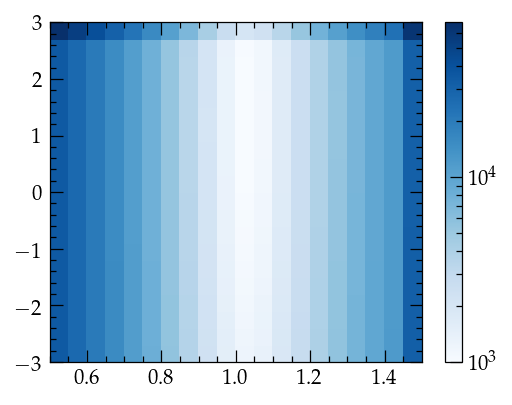

In [29]:
import matplotlib as mpl

fig, ax = plt.subplots()
h = ax.hist2d(
    X.ravel(), Y.ravel(),
    bins=(xs, ys),
    weights=Z.ravel(),
    norm=mpl.colors.LogNorm(),
    cmap="Blues",
)
cbar = fig.colorbar(h[3], ax=ax)
pass